In [3]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

import random

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [4]:
# Semilla para generación de números aleatorios
random.seed(67890)
np.random.seed(67890)

In [5]:
class CajaAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [6]:
class RobotAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        self.move()
        self.organize_boxes()

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def organize_boxes(self):
        cell_contents = self.model.grid.get_cell_list_contents([self.pos])
        boxes = [obj for obj in cell_contents if isinstance(obj, CajaAgent)]
        if len(boxes) > 0:
            if len(boxes) >= 5:
                return
            for neighbor in self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False):
                neighbor_contents = self.model.grid.get_cell_list_contents([neighbor])
                neighbor_boxes = [obj for obj in neighbor_contents if isinstance(obj, CajaAgent)]
                if len(neighbor_boxes) > 0:
                    box_to_move = neighbor_boxes[0]
                    self.model.grid.move_agent(box_to_move, self.pos)

In [7]:
class AlmacenModel(Model):
    def __init__(self, width, height, num_robots, num_boxes):
        self.num_agents = num_robots
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)

        # Crear robots en posiciones aleatorias
        for i in range(self.num_agents):
            a = RobotAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Crear cajas en posiciones aleatorias, agrupadas en 1 a 3 cajas por celda
        for i in range(num_boxes):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            num_cajas = self.random.randint(1, 3)
            for j in range(num_cajas):
                c = CajaAgent(num_boxes + j, self)
                self.grid.place_agent(c, (x, y))

        self.grid_history = []

    def step(self):
        self.schedule.step()
        self.record_grid()

    def check_stacks(self):
        for cell in self.grid.coord_iter():
            cell_content, coord = cell
            boxes = [obj for obj in cell_content if isinstance(obj, CajaAgent)]
            if 0 < len(boxes) < 5:
                return False
        return True

    def record_grid(self):
        grid_data = np.zeros((self.grid.width, self.grid.height))
        for cell in self.grid.coord_iter():
            cell_content, coord = cell
            x, y = coord
            for agent in cell_content:
                if isinstance(agent, CajaAgent):
                    grid_data[y][x] += 1
                elif isinstance(agent, RobotAgent):
                    grid_data[y][x] = 8  # Representar robots con un valor mayor
        self.grid_history.append(grid_data)

In [8]:
# Parámetros de simulación
GRID_SIZE = 20
ITERATIONS = 200

# Inicializar y correr el modelo
model = AlmacenModel(GRID_SIZE, GRID_SIZE, 5, 200)
for i in range(ITERATIONS):
    model.step()
    if model.check_stacks():
        break

NameError: name 'MultiGrid' is not defined

In [ ]:
# Convertir grid history a una lista de DataFrames para animación
all_grid = [grid for grid in model.grid_history]

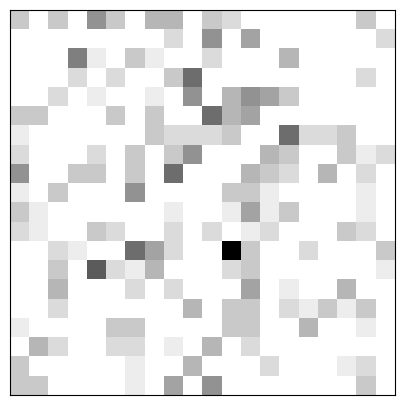

In [ ]:
# Crear la animación
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid[0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid[i])

anim = animation.FuncAnimation(fig, animate, frames=len(all_grid), repeat=False)
plt.show()

In [ ]:
anim